In [37]:
import numpy as np
from graph_tool.all import *
from scipy.stats import poisson as pois
from scipy.stats import zipf as zipf_distr
from scipy.stats import norm as snorm
import graph_tool.generation as gt
import time
import scipy
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [30]:
scipy.special.zeta(2, 1) 

1.6449340668482266

# Надо сделать:
-Научиться генерировать граф с заданным распределением на степени вершин - ОК    
-Дать каждой вершине +1 или -1 с заданными долями в зависимости от степени, или случайно - ОК   
-Визуализировать текущую ситуацию - ОК   
-Сделать шаг пересчета - ОК  
-Написать функцию для вычисления среднего поля и парных корелляций - ОК  
-Разбить вершины по квантилям на 3 группы в зависимости от степени - ОК  
-Написать генерацию степеней для пуассоновского распределения и степенного для k - параметр  
-Написать реализацию пуассоновских часов  
-Найти начиная с какого количества ребер происходит сходимость всех к одной стороне  
-Найти зависимость сходимости от $\sigma$ в нормальном распределении для разности шума  
-Переделать F для разности двух гауссовых распределений

# 1. Генерация графа с заданным распределением на степени вершин

Сделать для степеней вершин от 1 до кол-ва вершин в графе
взять $a = 2.5$
k = 1.. $\infty$ ~ $\frac{1}{k^a}$


In [6]:
SIZE = 500
GTYPE = 'pois'

In [67]:
zipf_distr.rvs(2.5, loc=0, size=500, random_state=None)

array([ 1,  3,  1,  1,  1,  1,  1,  1,  4,  2,  2,  2,  1,  1,  1,  1,  2,
        2,  1,  1,  1,  1,  8,  1,  1,  1,  1,  1,  3,  1,  1,  3,  1,  1,
        1,  1,  1,  3,  3,  1,  1,  8,  1,  2,  2,  2,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  3,  2,  1,  1,  2,  1,  1,  1,  1,  1,
        5,  2,  6,  1,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        3,  3,  1,  1,  1,  2,  1,  5,  3,  1,  1,  5,  1,  6,  1,  3,  2,
        1,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,  1,
        1,  1, 12,  1,  2,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  1,  2,  1,  1,  1,  7,  1, 13,  1,  2,
        1,  6, 14,  1,  1,  1,  3,  3, 30,  5,  2,  1,  1,  2,  1,  1,  1,
        1,  3,  1,  1,  1

In [2]:
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

In [3]:
def gen_graph():
    g = gt.random_graph(SIZE, get_vertex_degree, directed=False)
    labels = g.new_vertex_property("int")
    labels_hist = g.new_vertex_property("vector<int>")  
    vertices = [item for item in g.vertices()]

    # начальное распределение на вершины
    for vertex in vertices:
        labels[vertex] = np.random.binomial(1, 0.5, 1) * 2 - 1
        labels_hist[vertex].append(labels[vertex])
    pos = graph_tool.draw.sfdp_layout(g)
    
    return g, labels, labels_hist, pos

In [4]:
def clear_hist(labels_hist):
    max_deg = np.max([g.degree_property_map('out')[v] for v in g.vertices()])
    for v in g.vertices():
        labels_hist[v] = []

t = time.time()
g = gt.random_graph(SIZE, get_vertex_degree, directed=False)
labels = g.new_vertex_property("int")
labels_hist = g.new_vertex_property("vector<int>")  
vertices = [item for item in g.vertices()]

# начальное распределение на вершины
for vertex in vertices:
    labels[vertex] = np.random.binomial(1, 0.3, 1) * 2 - 1
    labels_hist[vertex].append(labels[vertex])
pos = graph_tool.draw.sfdp_layout(g)
graph_draw(g, pos, vertex_text = g.vertex_index, vertex_font_size=18, vertex_fill_color=labels,
       output_size=(400, 400), inline = True, output="two-nodes.png")
print "time = ", time.time() - t

### Функция для вычисления порядка в котором агенты пересматривают свои решения.
##### Вход:  
-суммарное количество агентов  
-суммарное количество пересмотров  
##### Выход:
-список из агентов в порядке очереди пересчета

In [7]:
# доделать для Пуассоновских часов у каждого
def get_queue(revisions_number, agents_number=SIZE):
    queue = np.random.randint(agents_number, size=revisions_number)
    return queue

## Функция распределения для $\varepsilon(1) - \varepsilon(-1)$

In [8]:
def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)

# Определим функцию для обновления меток на основании полезности

Переходная условная вероятность имеет вид  
$P(w_{it+} = 1| w_t) = F(2h + 2 \frac{J}{I-1} \sum\limits_{j \ne i} w_{jt}$, где   
$w_{it+}$ - выбор $i$-того агента в момент времени $t+1$  
$2h$ - коэффициент индивидуальной полезности, в программе $private \text{ } utility$  
$2 \frac{J}{I-1}$ - коэффициент полезности соответствия соседям, в программе $pairwise \text{ } utitily$  

## Функция для вычисления текущего среднего поля и парных корелляций

In [14]:
def calc_cur_stats(k=3, g=g, labels=labels):
    # параллельные списки из меток и степеней вершин
    vert_labels = np.array([labels[v] for v in g.vertices()])
    vert_degrees = np.array([g.degree_property_map('out')[v] for v in g.vertices()])
    vert_groups = np.zeros(len(vert_degrees)+1)
    # Определяем границы для разделения вершин по степеням на k групп
    bounds = [-1.0]
    for i in range(k-1):
        bounds.append(np.percentile(vert_degrees, 100.0 * (i+1) / k))
    
    bounds.append(np.max(vert_degrees))
    
    # Задаем группы вершинам в зависимости от степени
    
    # Создаем итоговые статистики: Средние метки
    mean_fields = []
    for i in range(k):
        indexes = np.array(vert_degrees > bounds[i]) * np.array(vert_degrees <= bounds[i+1])
        # Задаем группы вершинам в зависимости от степени
        vert_groups[indexes] = i
        mean_fields.append(np.mean(vert_labels[indexes]))
#        print len(bounded_labels)

    # Создаем итоговые статистики: Средние парные корелляции
    pair_corr = dict()
    for i in range(k):
        for j in range(k):
            pair_corr[(i, j)] = []
    for edge in g.edges():
        matr_index = (vert_groups[int(edge.source())], vert_groups[int(edge.target())])
        matr_index_inv = (matr_index[1], matr_index[0])
        
        matr_value = vert_labels[int(edge.source())] * vert_labels[int(edge.target())]
        
        pair_corr[matr_index].append(matr_value)
        pair_corr[matr_index_inv].append(matr_value)
    
    pair_corr_matr = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            pair_corr_matr[i, j] = np.mean(pair_corr[(i, j)])
    return mean_fields, pair_corr_matr

In [172]:
calc_cur_stats(3, g=g, labels=labels)

([0.95833333333333337, 1.0, 1.0],
 array([[ 0.87878788,  0.94805195,  0.98657718],
        [ 0.94805195,  1.        ,  1.        ],
        [ 0.98657718,  1.        ,  1.        ]]))

## Функция вычисления парных коррелляций и среднего поля в зависимости от степени
Функция разбивает вершины в зависимости от степени на $k$ групп (по квантилям) и возвращает пару из массива средних значений меток длины $k$ и матрицу парных корреляций размера $k*k$

In [13]:
def calc_statistics(k, g=g, labels_hist=labels_hist):
    # параллельные списки из истории меток и степеней вершин
    vert_hist = np.array([labels_hist[v] for v in g.vertices()])
    vert_degrees = np.array([g.degree_property_map('out')[v] for v in g.vertices()])
    
    # Определяем границы для разделения вершин по степеням на k групп
    bounds = [-1.0]
    for i in range(k-1):
        bounds.append(np.percentile(vert_degrees, 100.0 * (i+1) / k))
    
    bounds.append(np.max(vert_degrees))
#    print bounds
    # Заполняем словарь: степень вершины -> история эволюции
    max_len = np.max(vert_degrees)
    degree_labels = dict()
    for i in range(max_len+1):
        if any(vert_hist[vert_degrees == i]):
            degree_labels[i] = np.concatenate(vert_hist[vert_degrees == i])

    # Создаем итоговые статистики: Средние метки
    mean_labels = []
    for i in range(k):
        bounded_labels = list(np.concatenate(vert_hist[np.array(vert_degrees > bounds[i]) 
                                                        * np.array(vert_degrees <= bounds[i+1])]))
#        print len(bounded_labels)
        mean_labels.append(np.mean(bounded_labels))
    
    return mean_labels

In [12]:
def revise_label(agent_number, g=g, labels=labels, labels_hist=labels_hist, size=SIZE, cdf=cdf):
    private_utility = 0.0
    pairwise_utitily = 1.5
    v = g.vertex(agent_number)
    
#    print "prev label = ", labels[v], v
        
    neighbours = [item for item in v.out_neighbours()]
    neighbours_sum = np.sum([labels[v_neighb] for v_neighb in neighbours])
    prob = cdf(private_utility + pairwise_utitily*neighbours_sum)
    
#    print "prob = ", prob
    labels[v] = np.random.binomial(1, prob, 1) * 2 - 1
    labels_hist[v].append(labels[v])
#    print "post label = ", labels[v], v

In [15]:
g, labels, labels_hist, pos = gen_graph()
print calc_statistics(3, g, labels_hist)
queue = get_queue(30)
for vert_index in queue:
    revise_label(vert_index,g,labels,labels_hist)
temp = calc_statistics(3, g, labels_hist)

[-0.22222222222222221, -0.02564102564102564, -0.040000000000000001]


In [16]:
def test(queue_size, evo_points, test_number=5, parts_number=3, param='mean'):
    for i in range(test_number):
        print "Start iteration ", i+1, " of ", test_number
        g, labels, labels_hist, _ = gen_graph()
        
        res = []
        if param == 'mean':
            for j in range(parts_number+1):
                res.append([])
            for step in range(evo_points):
                queue = get_queue(queue_size, SIZE)
                for vert_index in queue:
                    revise_label(vert_index, g, labels, labels_hist, SIZE)
    #            temp = calc_statistics(parts_number, g, labels_hist)
                temp, corr = calc_cur_stats(3, g=g, labels=labels)

                for j in range(len(temp)):
                    res[j].append(temp[j])
                res[len(temp)].append(np.mean(temp))

                clear_hist(labels_hist)

            figure(figsize = (15, 4))
            plt.plot(res[0], label="low")
            plt.plot(res[1], label="medium")
            plt.plot(res[2], label="high")
        #    plt.plot(res[3], label="superHigh")

            plt.plot(res[3], label="mean", color='black')
            plt.legend(loc='best')

    # Пока что реализация для parts_number = 3
        if param == 'corr':
            for j in range(6):
                res.append([])
            for step in range(evo_points):
                queue = get_queue(queue_size, SIZE)
                for vert_index in queue:
                    revise_label(vert_index, g, labels, labels_hist, SIZE)

                _, corr = calc_cur_stats(3, g=g, labels=labels)

                for i in range(3):
                    res[i].append(corr[i, i])

                res[3].append(corr[0, 1])
                res[4].append(corr[0, 2])
                res[5].append(corr[1, 2])
                clear_hist(labels_hist)

            figure(figsize = (15, 4))
            plt.plot(res[0], label="low_low")
            plt.plot(res[1], label="medium_medium")
            plt.plot(res[2], label="high_high")
            plt.legend(loc='best')

            figure(figsize = (15, 4))
            plt.plot(res[3], label="low_medium")
            plt.plot(res[4], label="low_high")
            plt.plot(res[5], label="medium_high")
            plt.legend(loc='best')

## Зависимость сходимости от $\sigma$ в нормальном распределении

In [ ]:
def test_stability(queue_size=10, evo_points=200, test_number=5, parts_number=3)
    

In [26]:
np.max(np.random.normal(0, 1, 100000000))

5.7728163982367491

## 50 вершин, мало ребер
Протестируем на малом графе

Start iteration  1  of  5
50
Start iteration  2  of  5
50
Start iteration  3  of  5
50
Start iteration  4  of  5
50
Start iteration  5  of  5
50


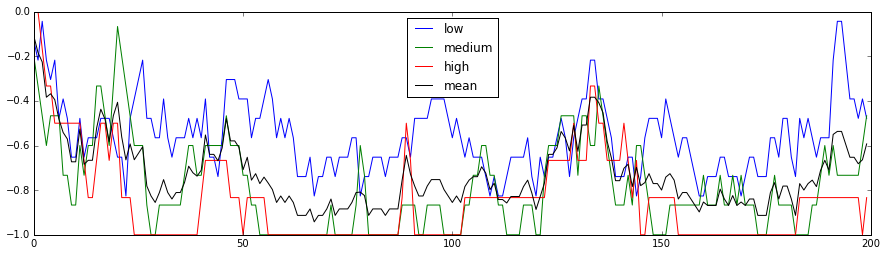

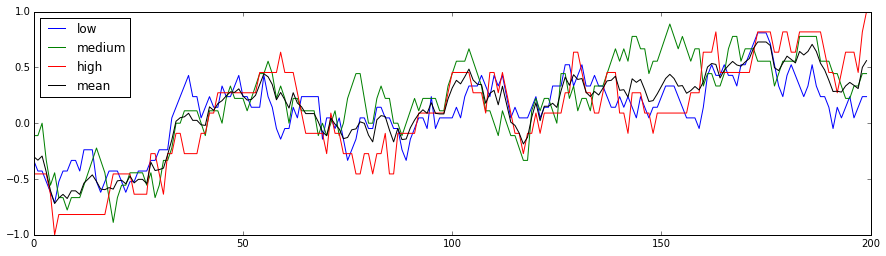

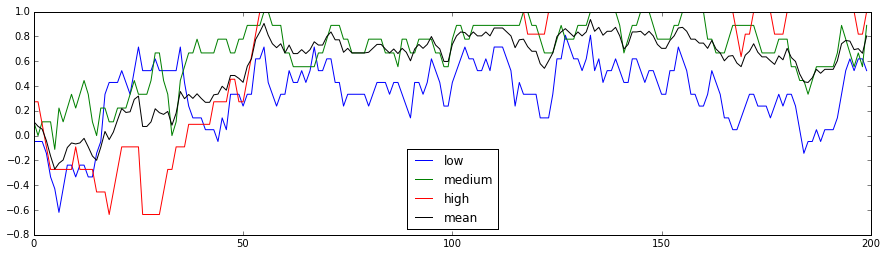

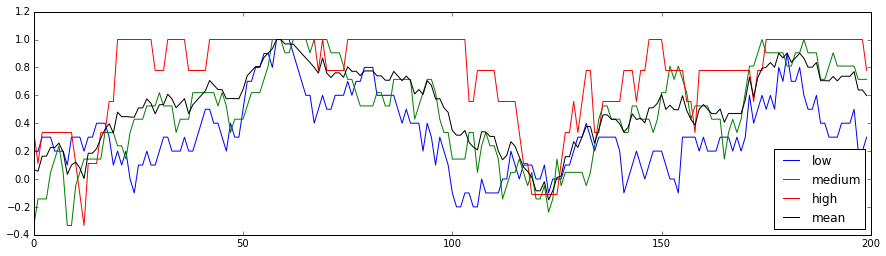

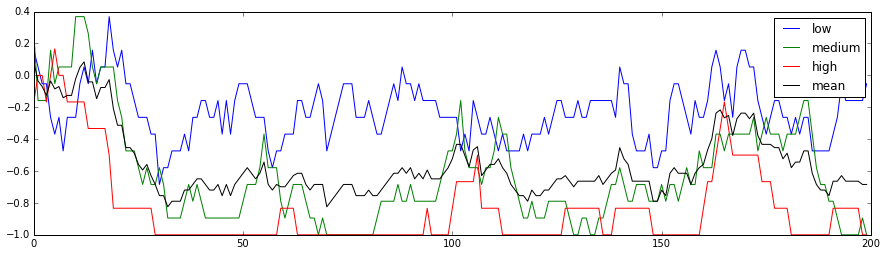

In [189]:
SIZE = 50
GTYPE = 'pois'
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

Агенты ведут себя крайне не стабильно, даже после почти полного доминирования одного из решений, достаточная доля агентов меняла общепринятое на противоположное. Соседей мало, поэтому этого влияния не достаточно, чтобы подавить случайную компоненту.

Попробуем увеличить число ребер в маленьком по числу вершин графе, переопределив генерирующую функцию

## 50 вершин, много ребер

In [191]:
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.5, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    

Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5


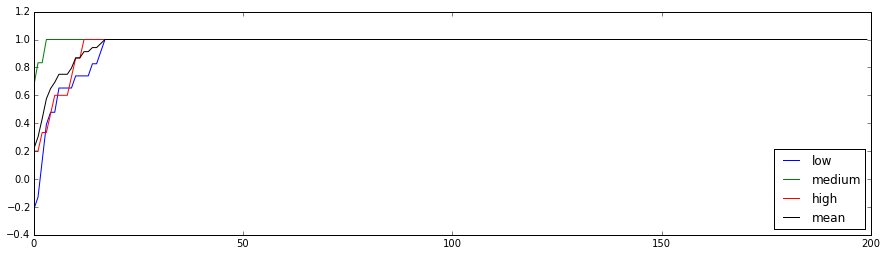

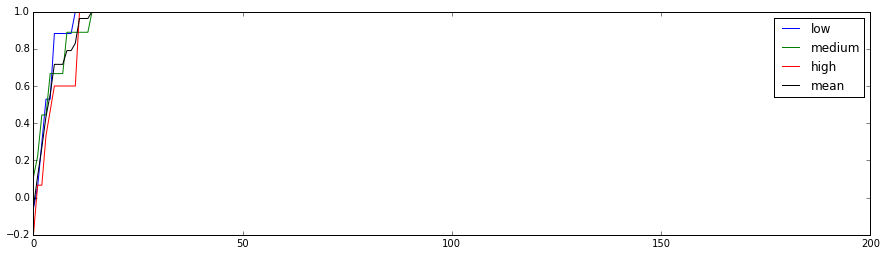

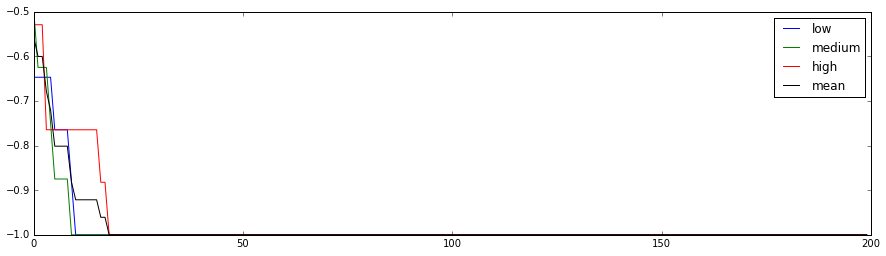

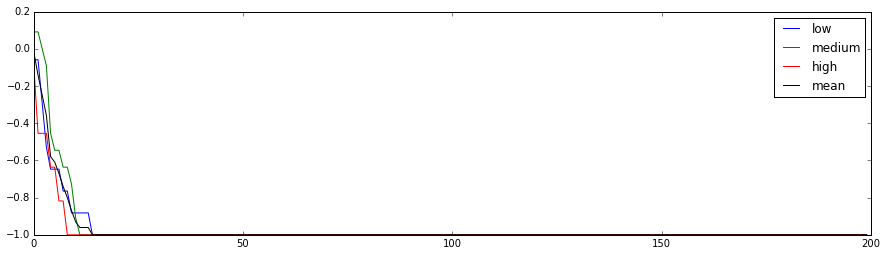

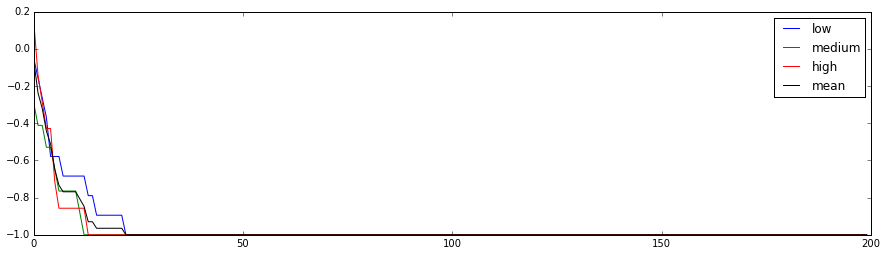

In [192]:
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

## 50 вершин, среднее число ребер

Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5


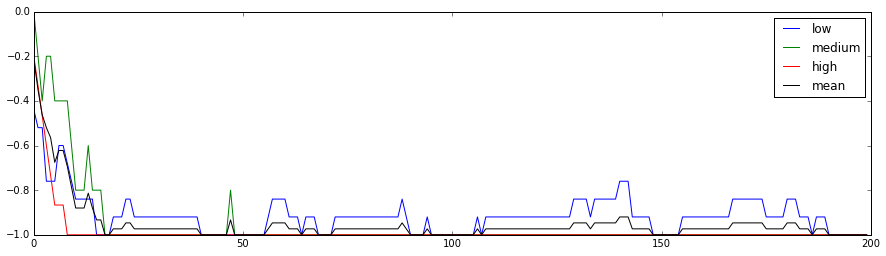

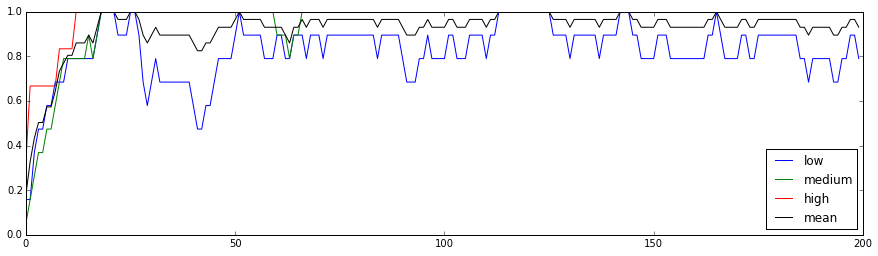

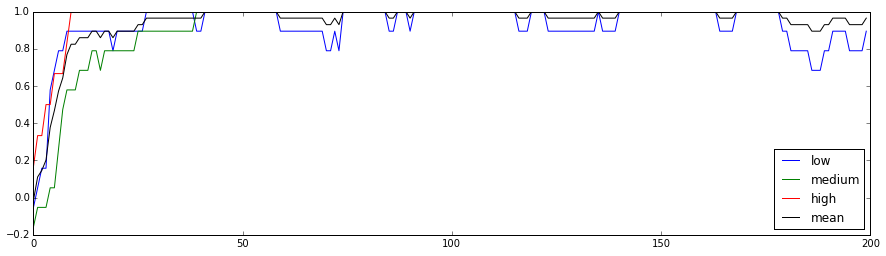

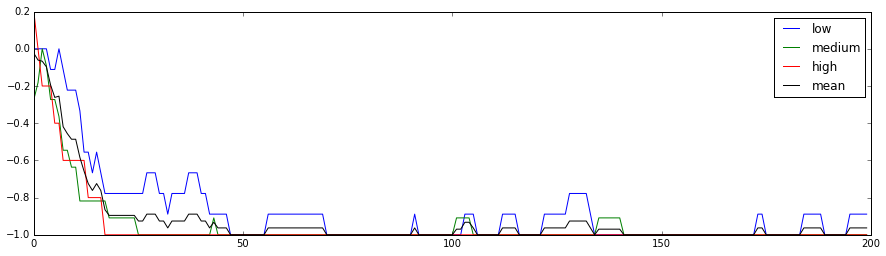

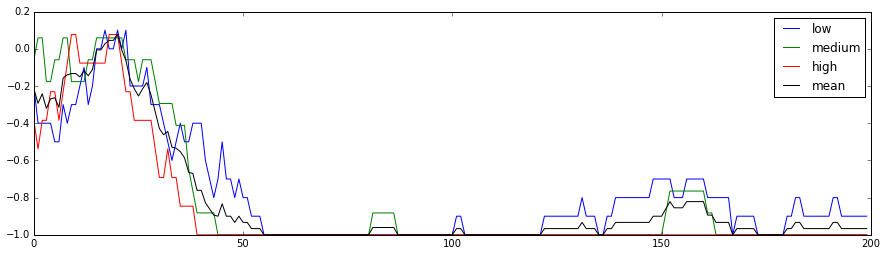

In [193]:
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.2, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5


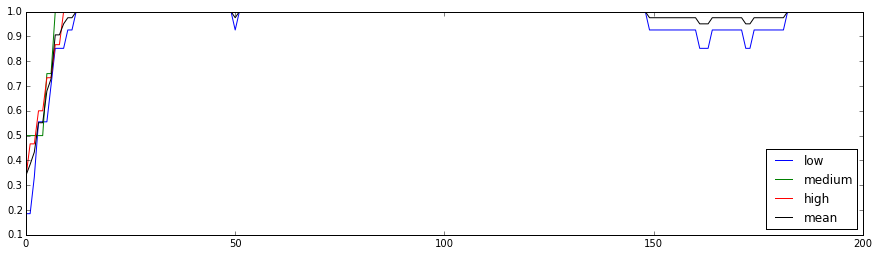

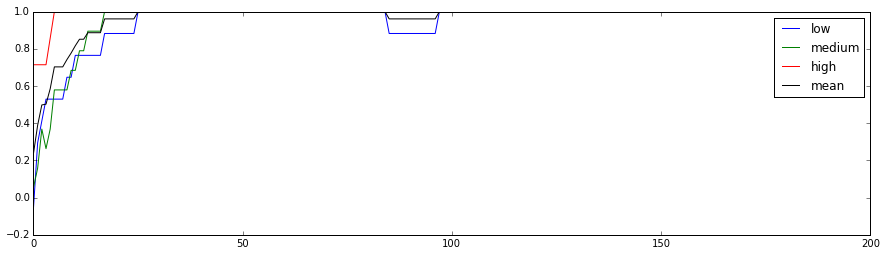

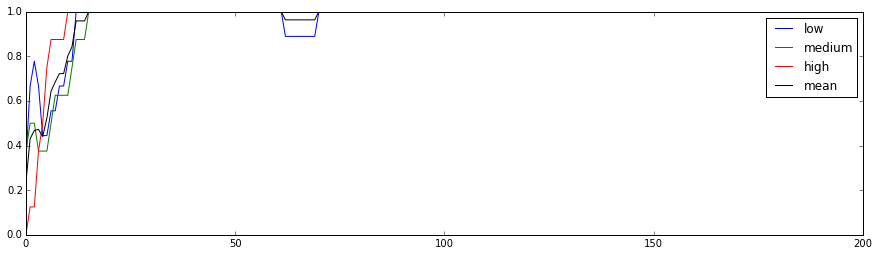

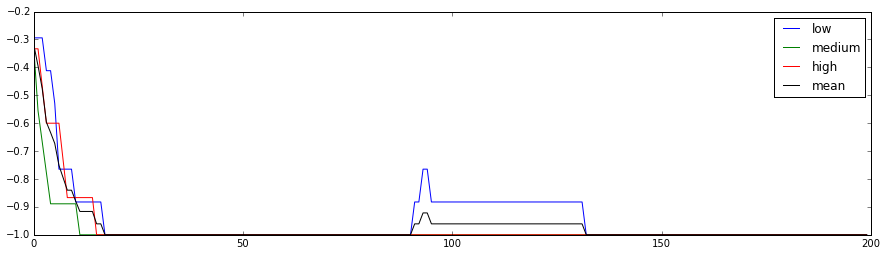

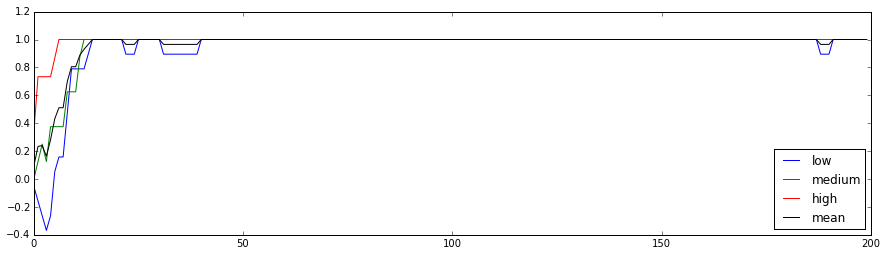

In [194]:
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.3, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

При средней степени вершины >10 наблюдается стабильность у средне и высоко степенных вершин

## 100 вершин, мало ребер

Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5


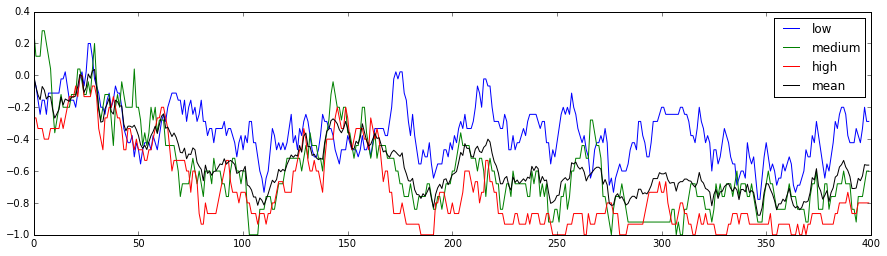

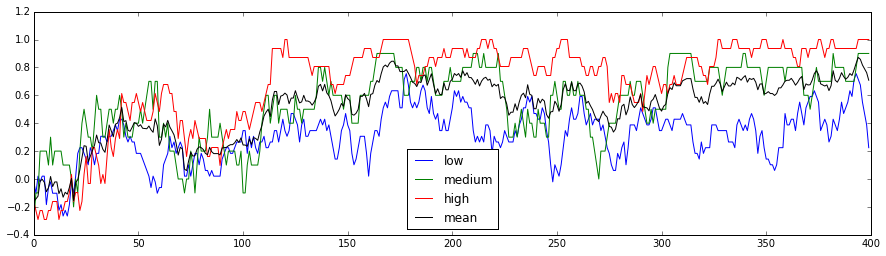

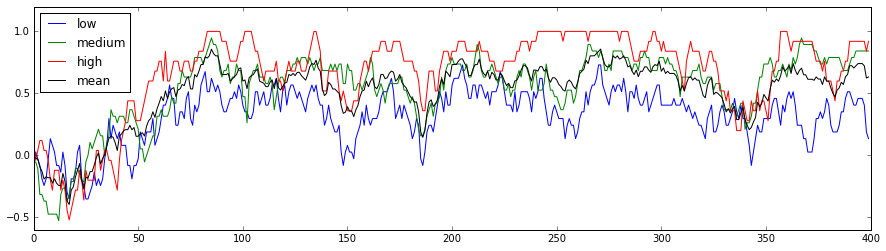

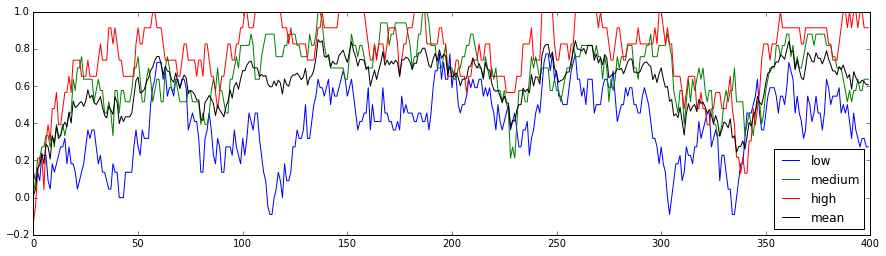

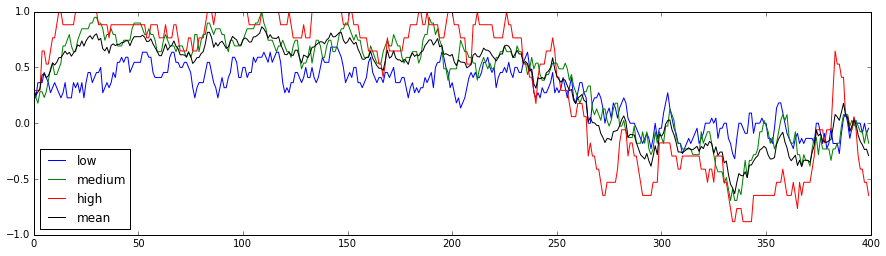

In [212]:
SIZE = 100
GTYPE = 'pois'
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.05, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=20, evo_points=400, test_number=5, parts_number=3 )

Наблюдаем интересный эффект: естесственно вершины большой степени стремятся к крайним значениям среднего в зависимости от интегрального среднего поля, но из-за малого числа ребер, эти крайние значения могут меняться в процессе эволюции

Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5


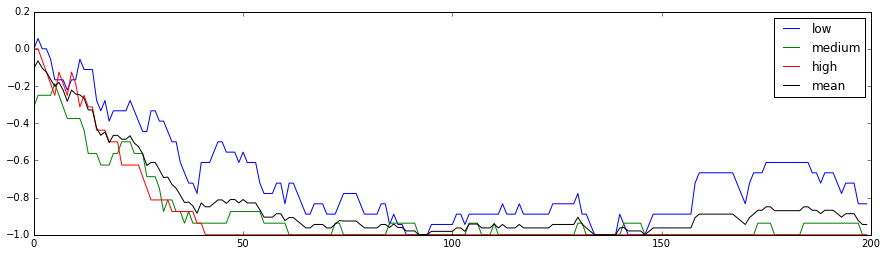

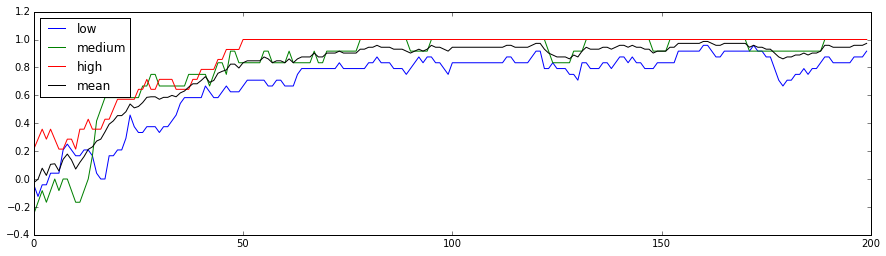

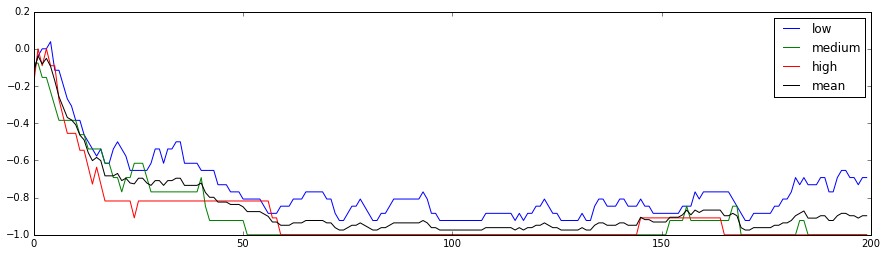

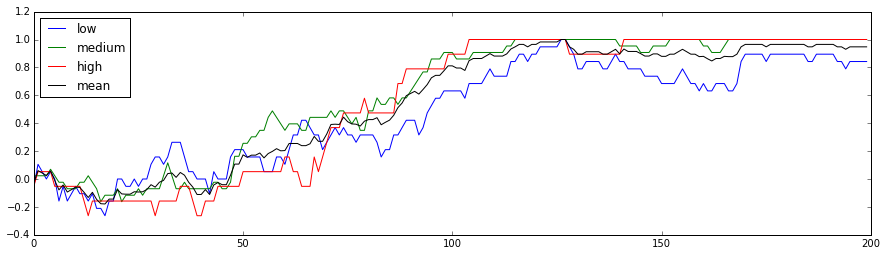

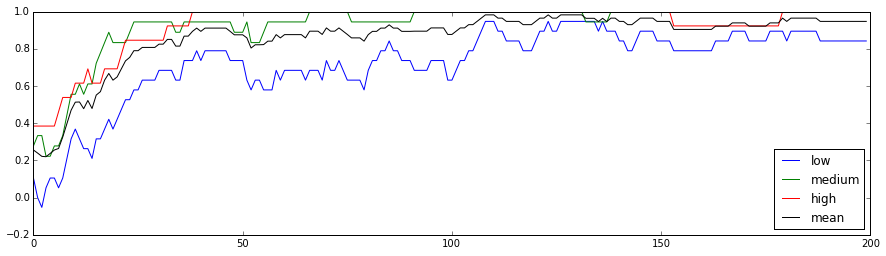

In [209]:
SIZE = 100
GTYPE = 'pois'
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.08, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5


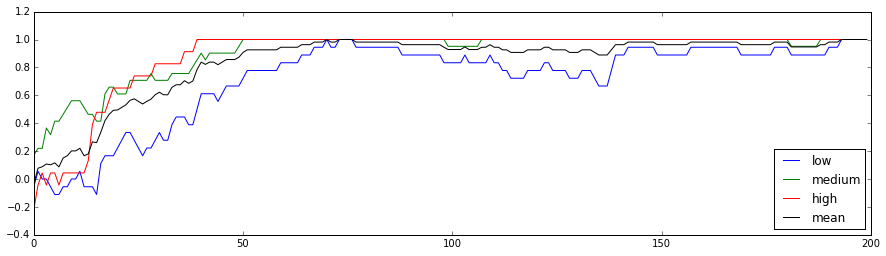

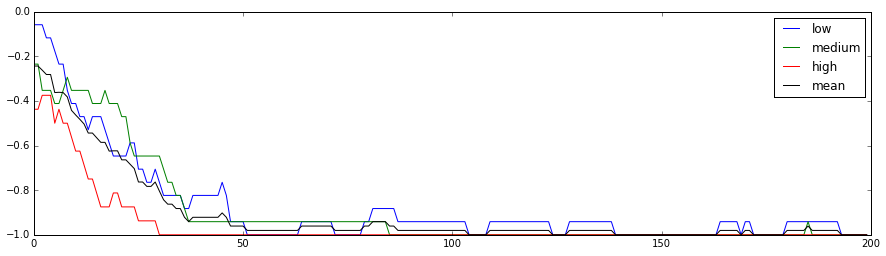

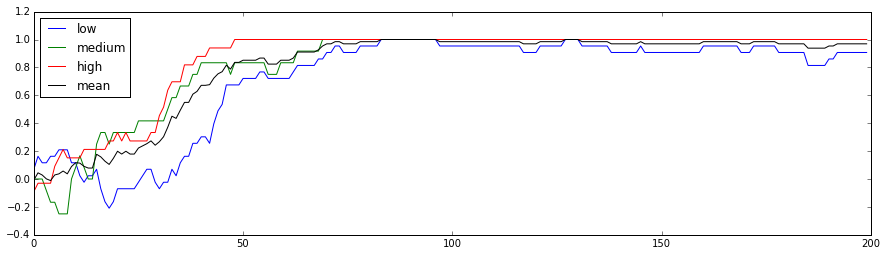

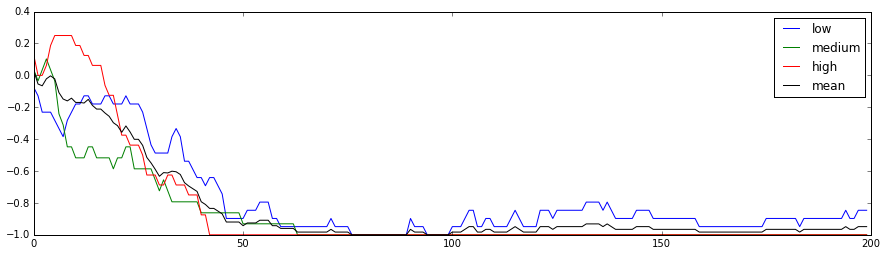

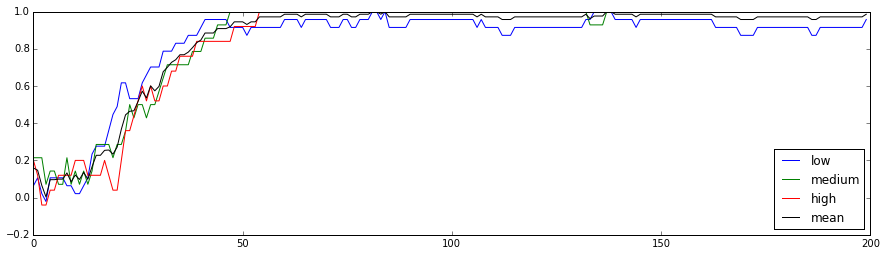

In [210]:
SIZE = 100
GTYPE = 'pois'
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5
Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5


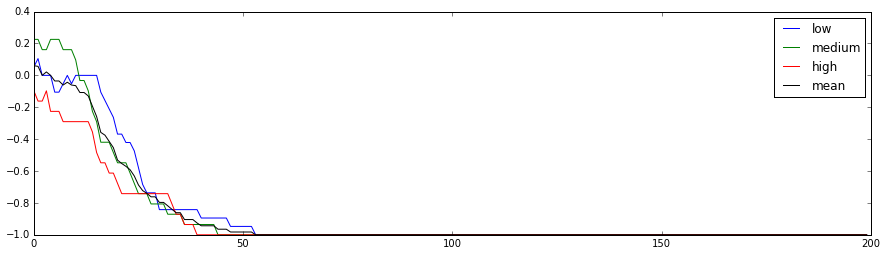

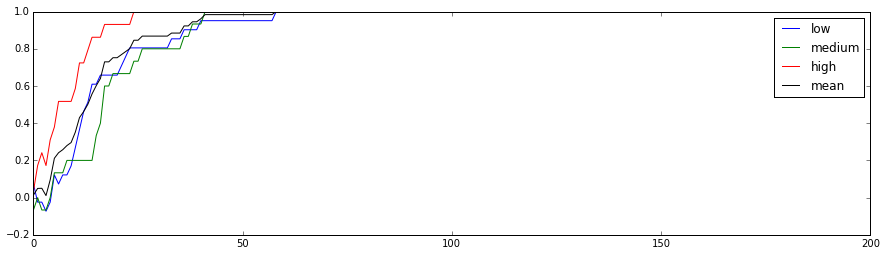

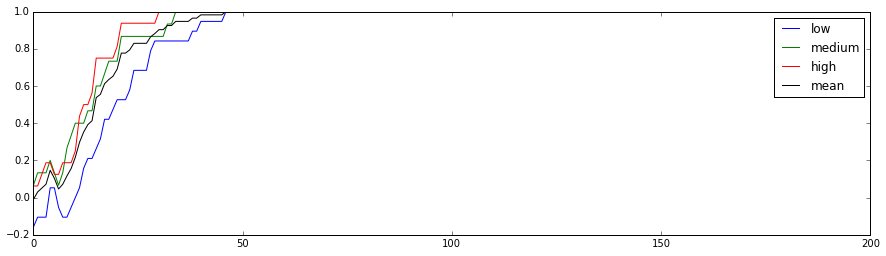

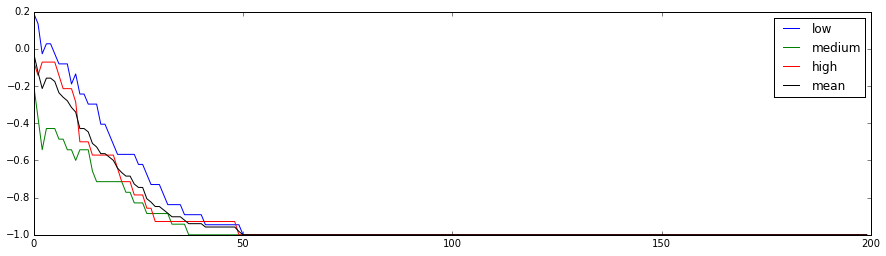

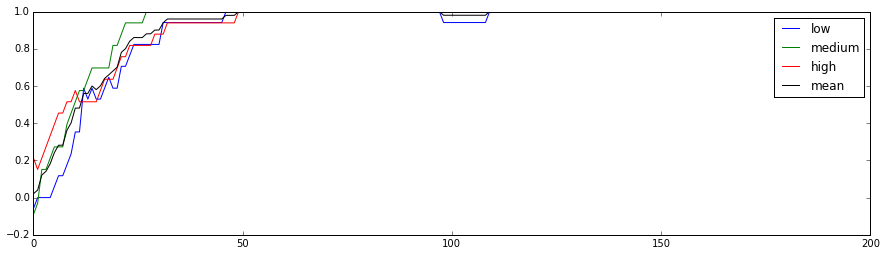

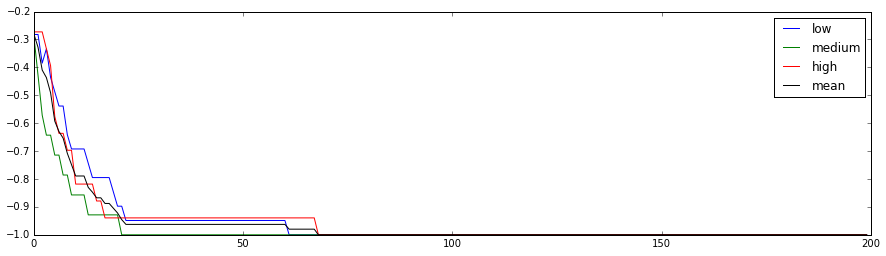

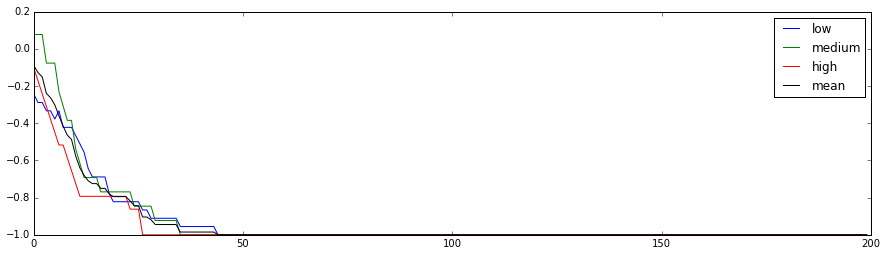

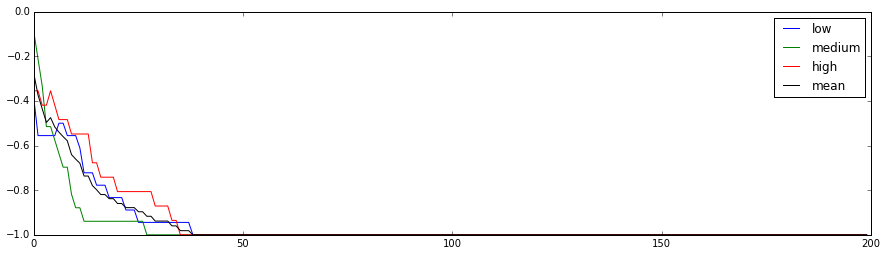

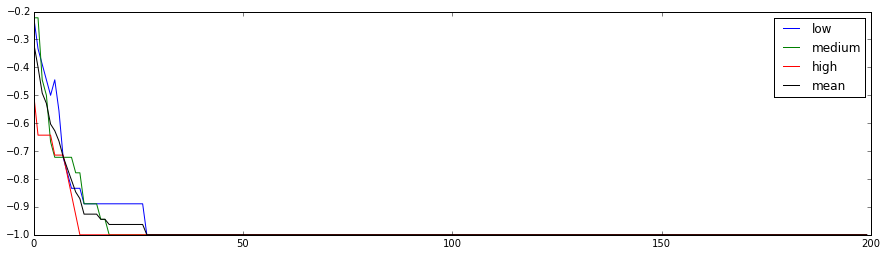

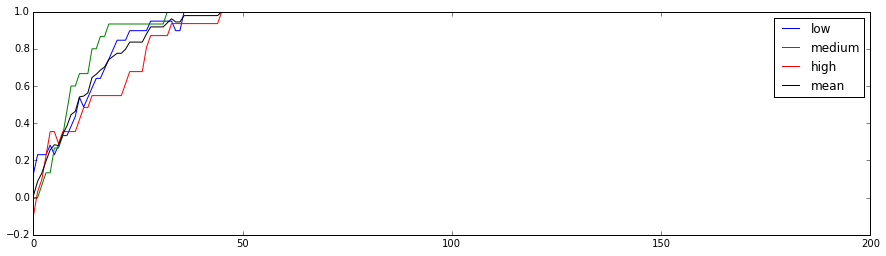

In [206]:
SIZE = 100
GTYPE = 'pois'
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.2, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

## 200 вершин, мало ребер

Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5


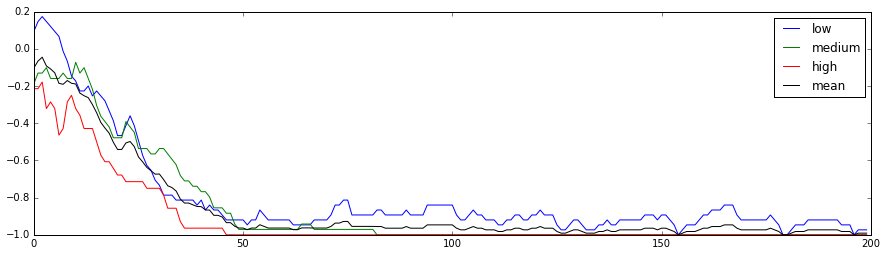

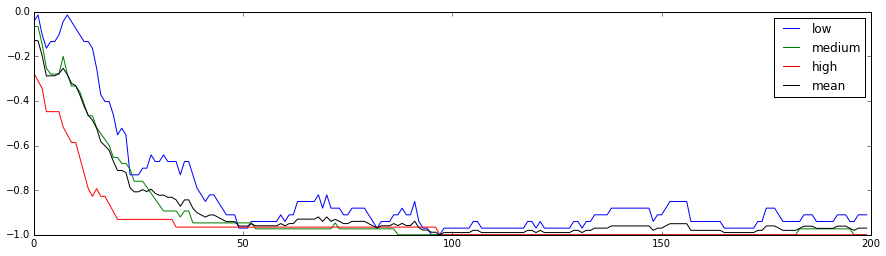

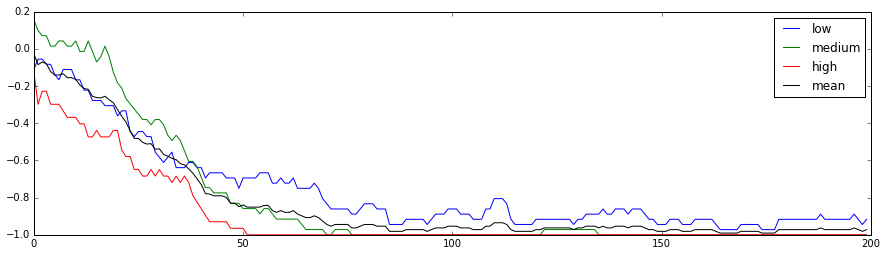

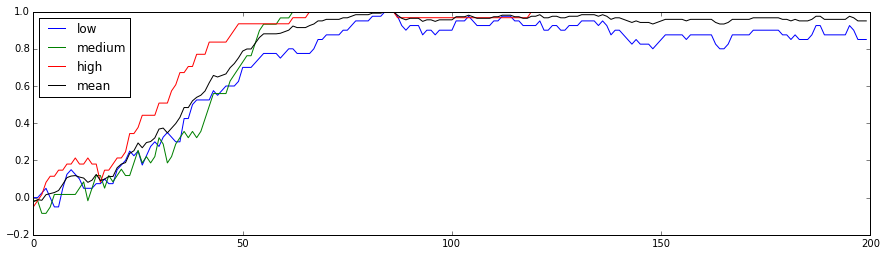

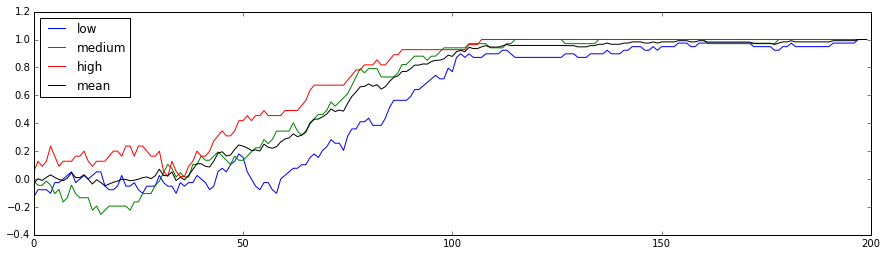

In [213]:
SIZE = 200
GTYPE = 'pois'
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.05, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=20, evo_points=200, test_number=5, parts_number=3 )


Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5
Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5


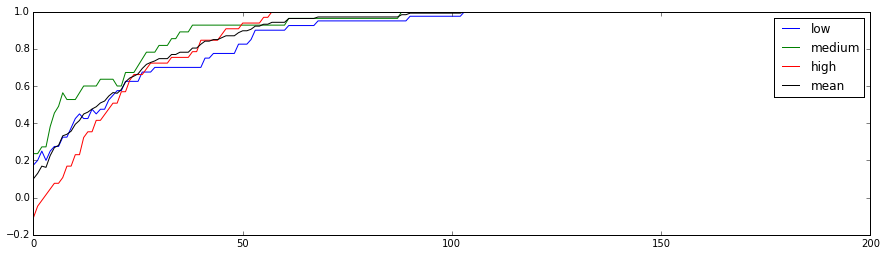

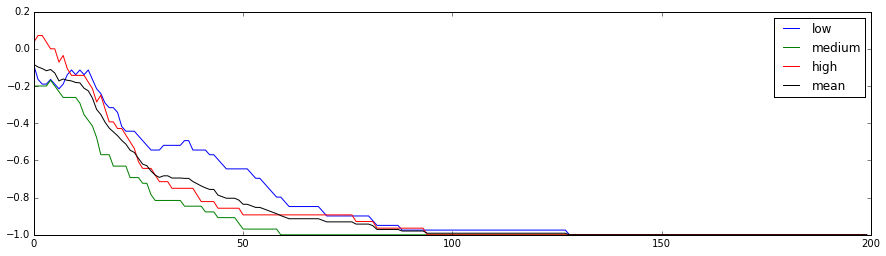

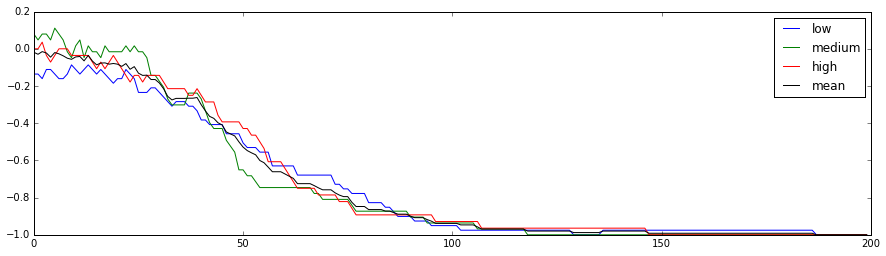

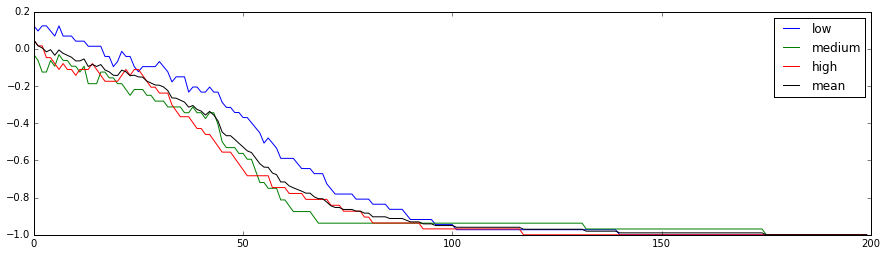

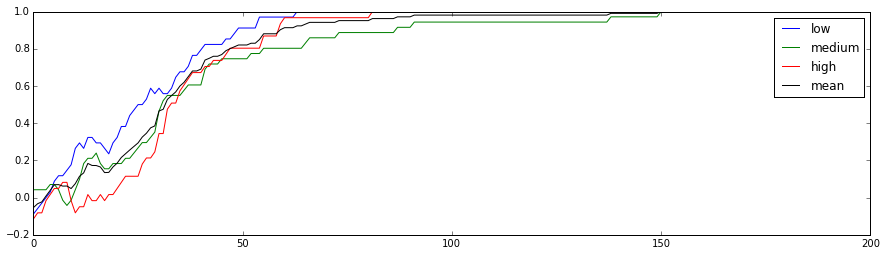

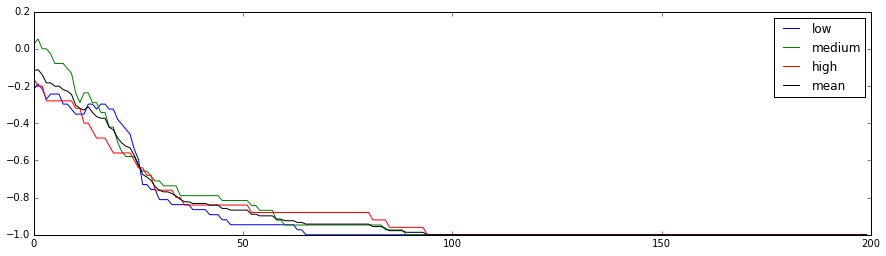

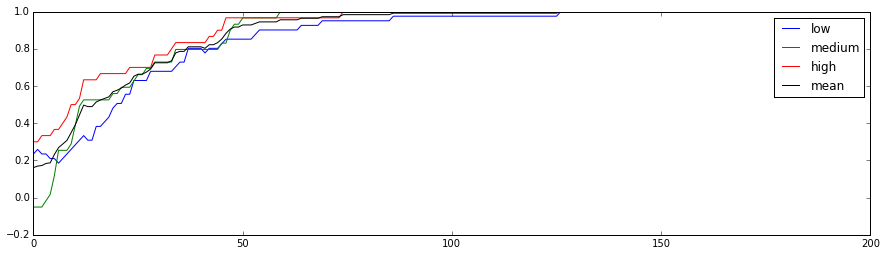

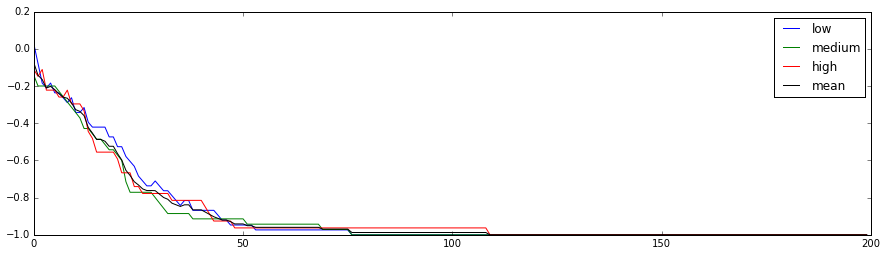

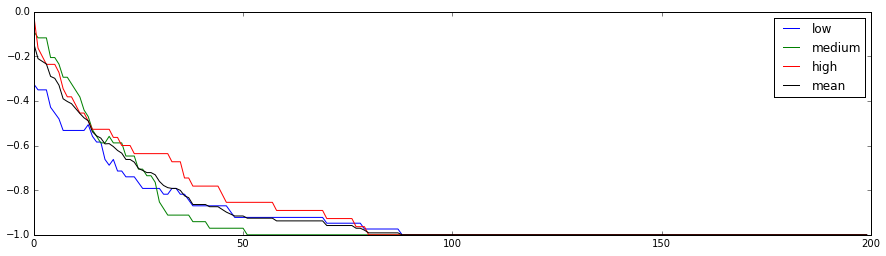

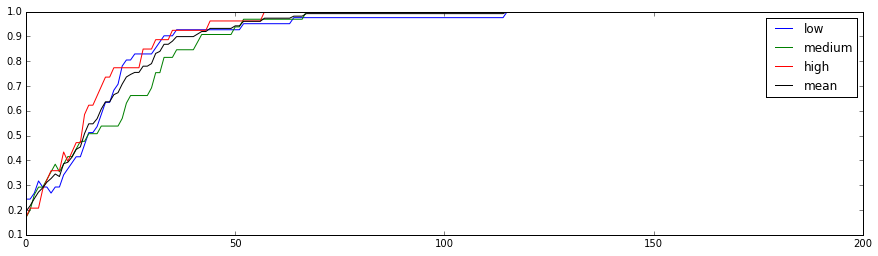

In [211]:
SIZE = 200
GTYPE = 'pois'
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

## Графики для корреляций 200 вершин, пуассоновский граф

Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5


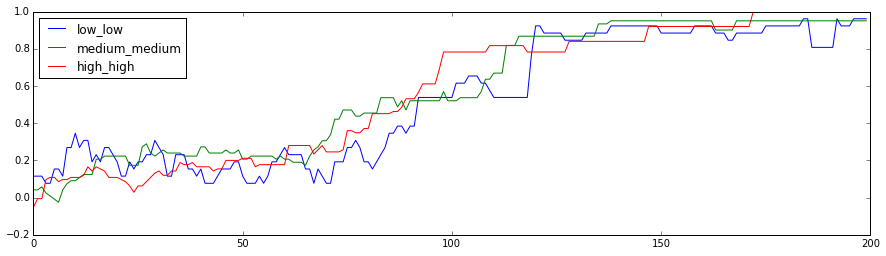

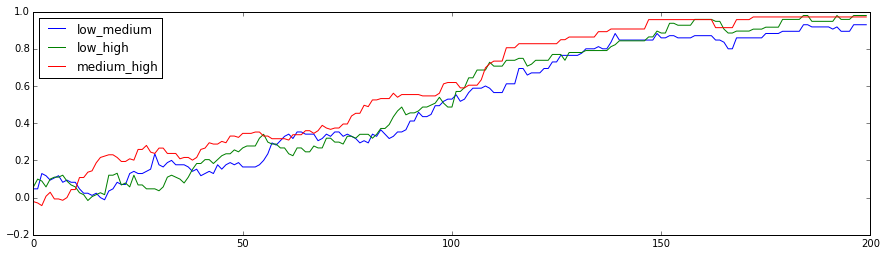

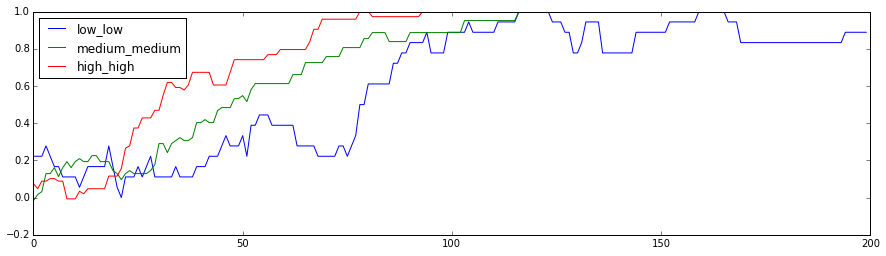

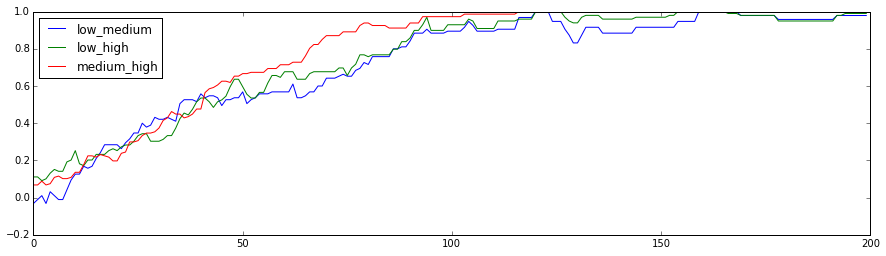

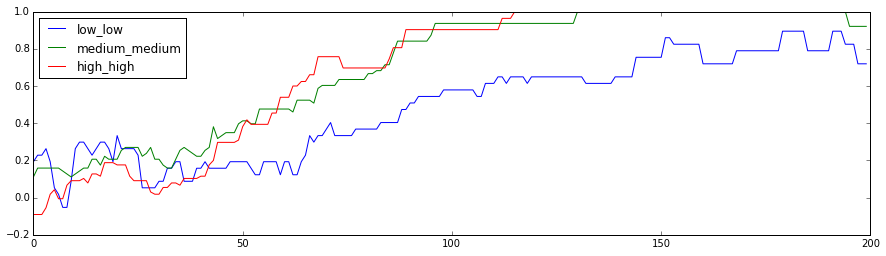

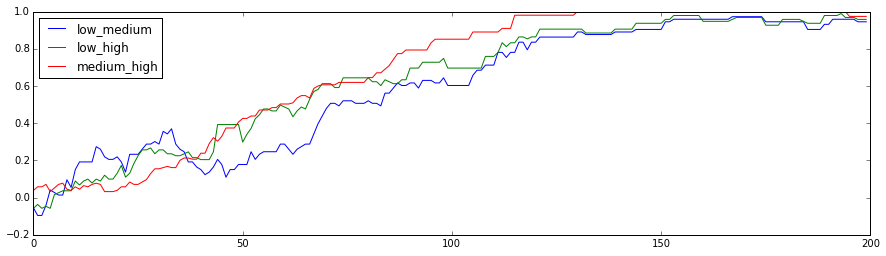

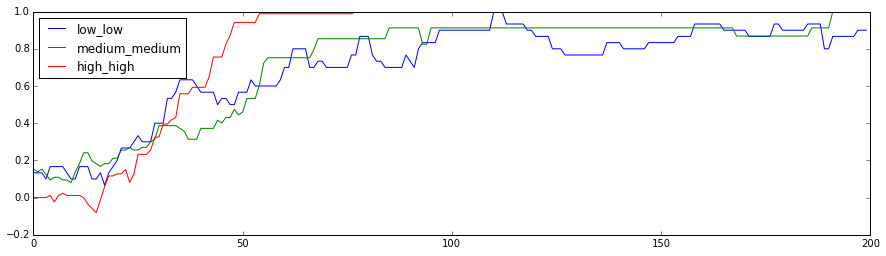

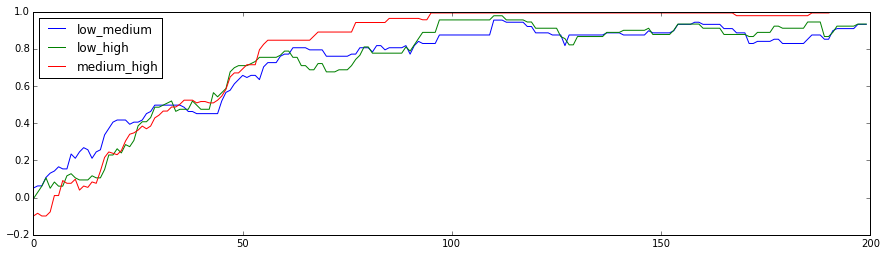

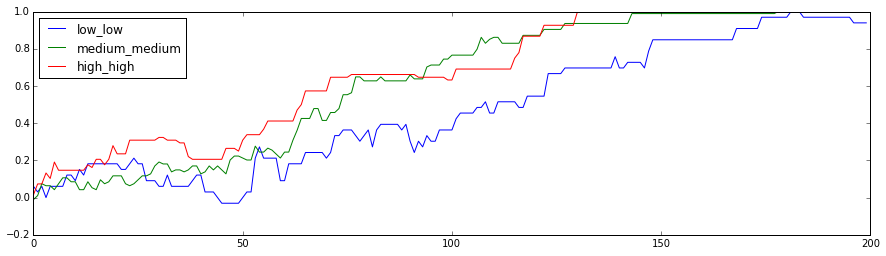

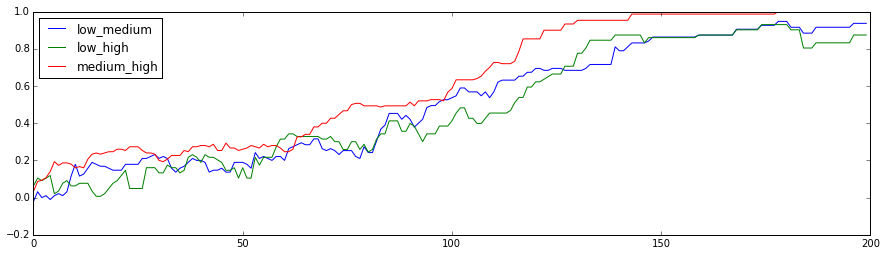

In [223]:
test(queue_size=10, evo_points=200, test_number=5, parts_number=3, param='corr')

## Большой граф
1000 вершин, средняя степень ~100

Start iteration  1  of  20
Start iteration  2  of  20
Start iteration  3  of  20
Start iteration  4  of  20
Start iteration  5  of  20
Start iteration  6  of  20
Start iteration  7  of  20
Start iteration  8  of  20
Start iteration  9  of  20
Start iteration  10  of  20
Start iteration  11  of  20
Start iteration  12  of  20
Start iteration  13  of  20
Start iteration  14  of  20
Start iteration  15  of  20
Start iteration  16  of  20
Start iteration  17  of  20
Start iteration  18  of  20
Start iteration  19  of  20
Start iteration  20  of  20


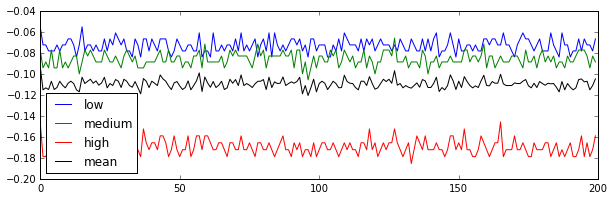

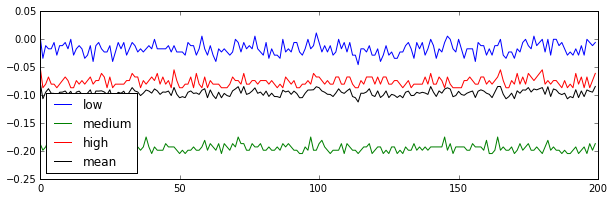

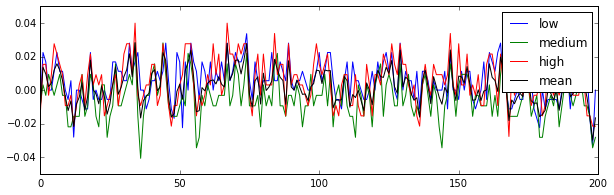

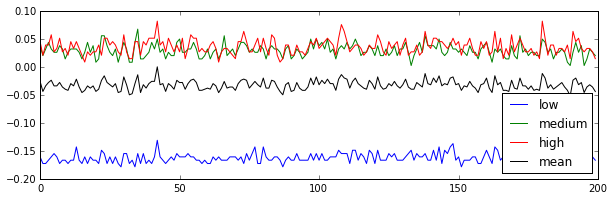

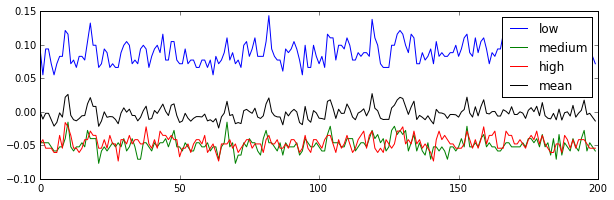

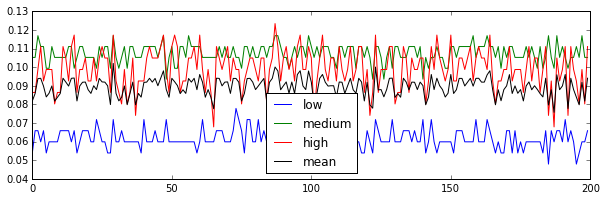

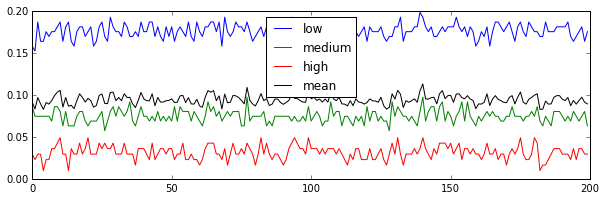

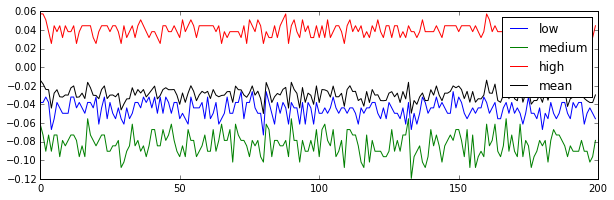

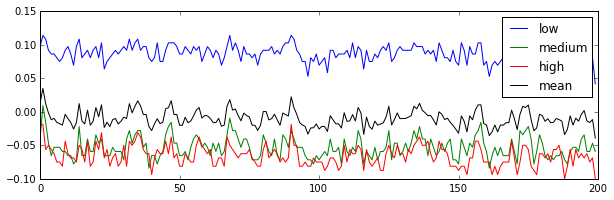

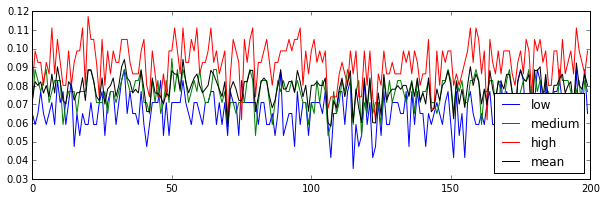

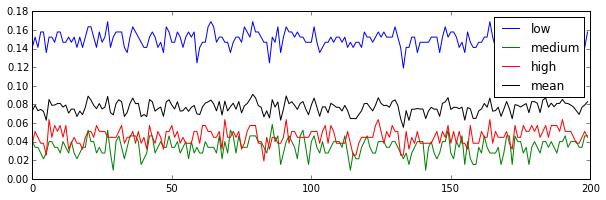

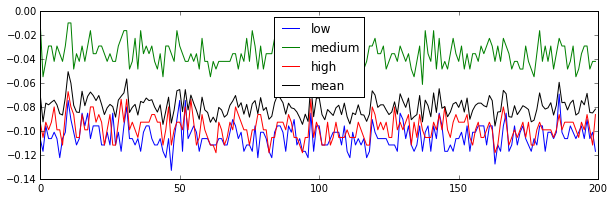

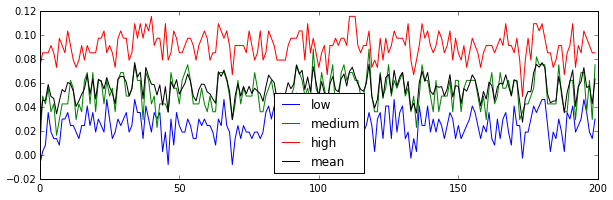

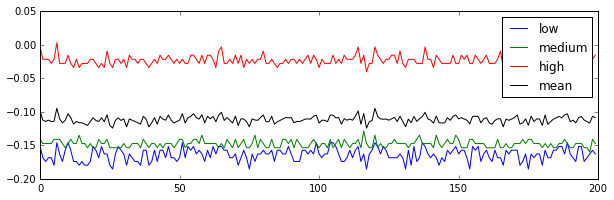

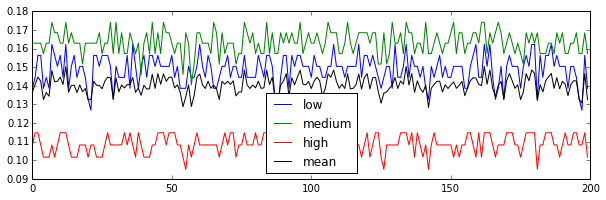

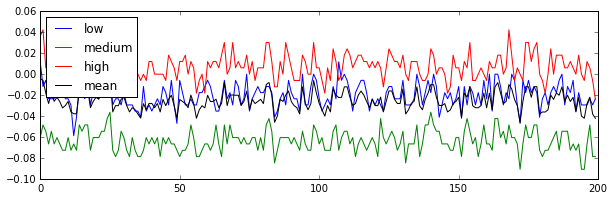

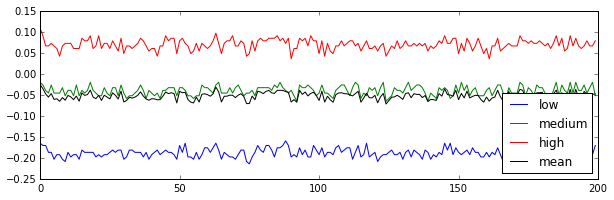

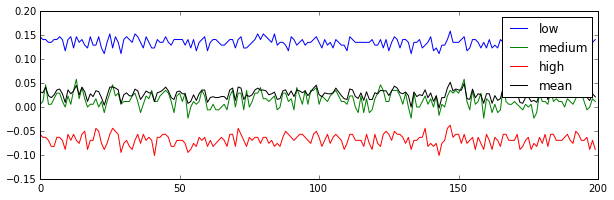

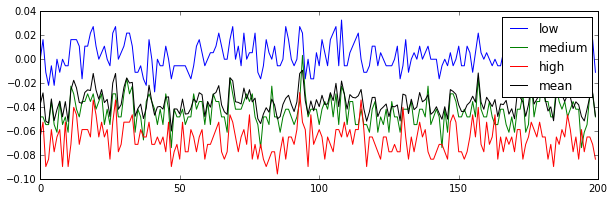

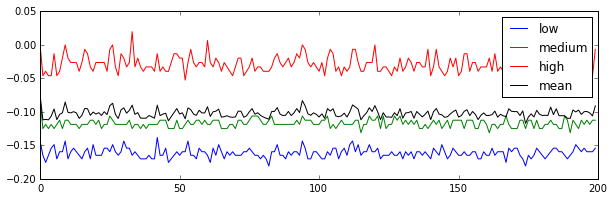

In [181]:
test(queue_size=500, evo_points=200, test_number=20, parts_number=3 )

In [ ]:
print calc_statistics(3)